In [ ]:
%matplotlib inline

In [ ]:
!pip install pandas
import pandas as pd

!pip install matplotlib
import matplotlib.pyplot as plt

!pip install numpy
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)
plt.style.use('ggplot')

# Задача про датчики на руках

В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными данными являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [ ]:
# Загружаем данные сенсоров
df_database = pd.read_csv('https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/sign_database.csv')

# Загружаем метки классов
sign_classes = pd.read_csv('https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [ ]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

,x_l,x_r,y_l,y_r,z_l,z_r,roll_l,roll_r,pitch_l,pitch_r,yaw_l,yaw_r,thumb_l,thumb_r,forefinger_l,forefinger_r,middle_l,middle_r,ring_l,ring_r,little_l,little_r,id,time
0,-0.097816,-0.127761,-0.029051,0.537977,0.249162,0.508908,0.239445,0.039819,0.0,0.007009,0.019041,0.046011,-0.106124,-0.006852,0.369149,0.381857,0.570995,0.343431,0.0,0.000000,0.0,0.133088,0,0
1,-0.102460,-0.126734,-0.029230,0.537758,0.246477,0.507236,0.240116,0.039057,0.0,0.007009,0.019041,0.047708,-0.050000,-0.009621,0.326618,0.402561,0.595044,0.291571,0.0,0.000000,0.0,0.084865,0,1
2,-0.103085,-0.125618,-0.028605,0.537464,0.244890,0.507273,0.234753,0.039057,0.0,0.007494,0.019041,-0.006363,-0.029461,0.017169,0.295135,0.436131,0.639491,0.242470,0.0,0.000000,0.0,0.026230,0,2
3,-0.102639,-0.126020,-0.028873,0.537306,0.244890,0.507639,0.232072,0.026864,0.0,0.009431,0.019041,-0.085527,-0.003653,0.138081,0.239311,0.521583,0.723905,0.224264,0.0,0.014668,0.0,0.015033,0,3
4,-0.105139,-0.127538,-0.028917,0.537513,0.244816,0.506626,0.234083,0.026864,0.0,0.008947,0.019041,-0.026098,0.100024,0.153798,0.199478,0.675103,0.786566,0.235298,0.0,0.010813,0.0,0.000815,0,4


In [ ]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

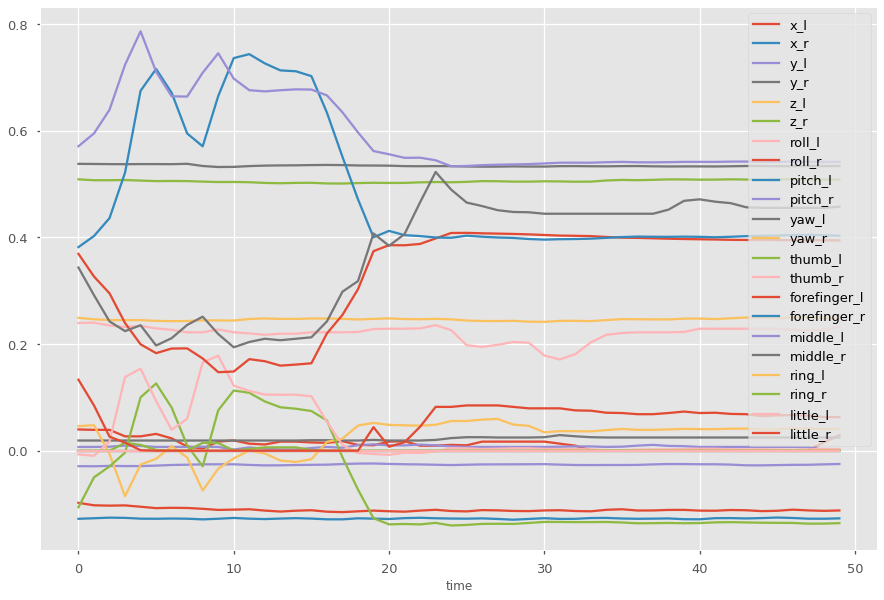

In [ ]:
sign0.plot()

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

In [ ]:
!pip install scikit-learn
from sklearn.preprocessing import LabelEncoder

In [ ]:
!wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O tsfresh_features_filt.csv.gz
filepath = 'tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath)

--2021-11-21 18:17:18--  https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz [following]
--2021-11-21 18:17:19--  https://www.dropbox.com/s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc713596915beb044efad167266.dl.dropboxusercontent.com/cd/0/inline/BabDYyGf80xEkYh3hY7CUOR-yNWwHgWFZk3GUwTqPKURdCzrjUQqtM6RFHSl2F2_41nnPe2yTjbCsdTi38OdsB2kmoU8h0sUHD8ra2N70xAPGbcwzxnrTl-1Db2RhUKpdkG9vP1lj-LkZ5mqPJt_NGu4/file# [following]
--2021-11-21 18:17:19--  https://ucc713596915beb044efad167266.dl.dropboxusercontent.com/cd/0/inline/BabDYyGf80xEkYh3hY7CUOR-yNWwHgWFZk

In [ ]:
sign_features_filtered.shape

(2565, 11517)

In [ ]:
sign_features_filtered.head()

,Unnamed: 0,ring_r__maximum,"ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","ring_r__fft_coefficient__attr_""abs""__coeff_2","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",ring_r__variance,ring_r__standard_deviation,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","ring_r__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","ring_r__fft_coefficient__attr_""abs""__coeff_1","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""var""","ring_r__fft_coefficient__attr_""imag""__coeff_1","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","ring_r__linear_trend__attr_""slope""","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""",ring_r__cid_ce__normalize_False,"ring_r__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","ring_r__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)","ring_r__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)","ring_r__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","ring_r__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","ring_r__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""",...,y_r__has_duplicate_max,x_r__large_standard_deviation__r_0.45,x_r__large_standard_deviation__r_0.15000000000000002,yaw_l__symmetry_looking__r_0.25,yaw_l__symmetry_looking__r_0.15000000000000002,roll_r__symmetry_looking__r_0.15000000000000002,roll_r__symmetry_looking__r_0.2,forefinger_r__has_duplicate_min,forefinger_r__symmetry_looking__r_0.05,roll_l__symmetry_looking__r_0.15000000000000002,roll_l__symmetry_looking__r_0.1,forefinger_r__symmetry_looking__r_0.1,forefinger_r__symmetry_looking__r_0.35000000000000003,z_r__large_standard_deviation__r_0.45,forefinger_r__large_standard_deviation__r_0.2,forefinger_r__large_standard_deviation__r_0.45,yaw_r__large_standard_deviation__r_0.4,forefinger_l__has_duplicate_min,thumb_r__large_standard_deviation__r_0.35000000000000003,thumb_r__symmetry_looking__r_0.35000000000000003,thumb_r__symmetry_looking__r_0.30000000000000004,z_r__symmetry_looking__r_0.35000000000000003,forefinger_l__large_standard_deviation__r_0.45,thumb_l__large_standard_deviation__r_0.45,thumb_l__large_standard_deviation__r_0.25,thumb_l__symmetry_looking__r_0.4,thumb_l__symmetry_looking__r_0.1,middle_l__symmetry_looking__r_0.35000000000000003,pitch_l__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.2,forefinger_l__large_standard_deviation__r_0.15000000000000002,little_r__symmetry_looking__r_0.15000000000000002,z_l__symmetry_looking__r_0.35000000000000003,roll_r__large_standard_deviation__r_0.25,roll_r__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.05,pitch_l__symmetry_looking__r_0.05,z_l__large_stand

# Базовая модель

В результате у нас получилось очень много признаков (11516 или больше), давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [ ]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes.values

In [ ]:
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [ ]:
base_cv_scores.mean()

0.9196881091617932

### Пайплайн с PCA

In [ ]:
scaler = StandardScaler()
Z = scaler.fit_transform(X)

In [ ]:
pca = PCA(svd_solver='randomized', random_state=123)
Z = pca.fit_transform(Z)

In [ ]:
ob_dis = pca.explained_variance_ratio_

Рассматриваем только те дисперсии, которые превышают значение 1e-3, потому что дальше, чтобы увеличить кол-во информации на условную единицу надо прибавлять больше компонент

In [ ]:
upper1e3 = np.cumsum(ob_dis[np.where(ob_dis > 1e-3)])

print(f'Количество информации в первых {len(upper1e3)} компонентах: {upper1e3[-1]}')

Количество информации в первых 134 компонентах: 0.692767776094044


In [ ]:
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

model_with_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('PCA', PCA(svd_solver='randomized', random_state=123, n_components=len(upper1e3))),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

pca_cv_scores = cross_val_score(model_with_pca, X, y, cv=cv, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [ ]:
pca_cv_scores.mean()

0.9115009746588694

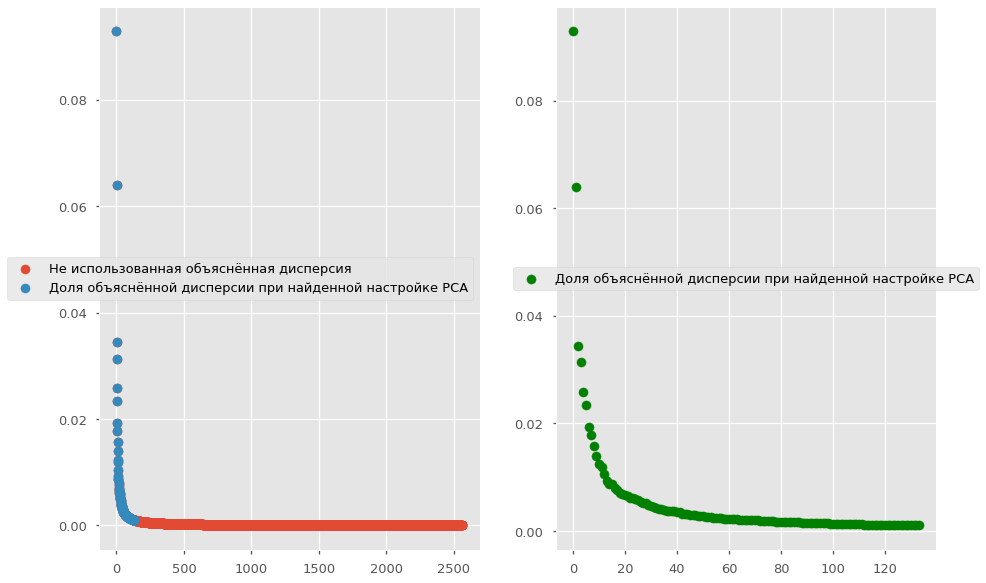

In [ ]:
using_dis = ob_dis[np.where(ob_dis > 1e-3)]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(range(ob_dis.shape[0]), ob_dis)
ax1.scatter(range(using_dis.shape[0]), using_dis)

ax2.scatter(range(using_dis.shape[0]), using_dis, c='g')

ax1.legend( ['Не использованная объяснённая дисперсия','Доля объяснённой дисперсии при найденной настройке PCA'])

ax2.legend(['Доля объяснённой дисперсии при найденной настройке PCA'], loc=10)

# Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:

* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано
* его рубрика


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/news.csv', encoding='utf8')
df.head()

,text,date,event,class
0,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,"Google Новости ТОП, Москва, 14 января 2017 АК...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ


In [ ]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Проишествия  РФ                                  100
Спорт                                            100
Внутренняя политика: культура                    100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубликами с помощью ARI

### Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов.

In [ ]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [ ]:
!pip install nltk
import nltk

In [ ]:
from nltk.corpus import stopwords

nltk.download('stopwords')

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)   

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz

--2021-11-21 18:20:14--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.245, 5.45.205.244, 5.45.205.241, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.245|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-man01i.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-11-21 18:20:15--  http://cache-man01i.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-man01i.cdn.yandex.net (cache-man01i.cdn.yandex.net)... 5.45.205.221, 2a02:6b8::3:221
Connecting to cache-man01i.cdn.yandex.net (cache-man01i.cdn.yandex.net)|5.45.205.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linux3.1 100%[===================>]  15.70M  5

In [ ]:
%%time 
from pymystem3 import Mystem


# нормализуем текст
bin_path = "./mystem"
m = Mystem(bin_path)
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 3.84 s, sys: 242 ms, total: 4.08 s
Wall time: 26.5 s


In [ ]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Еще кое-что удаляем
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

### Вычисление сходства (1 балл)

In [ ]:
!pip install seaborn
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [ ]:
vect = TfidfVectorizer()
texts = df.text.values

In [ ]:
tfidf = vect.fit_transform(texts)

In [ ]:
S = pairwise_distances(tfidf, metric='cosine')

[[], []]

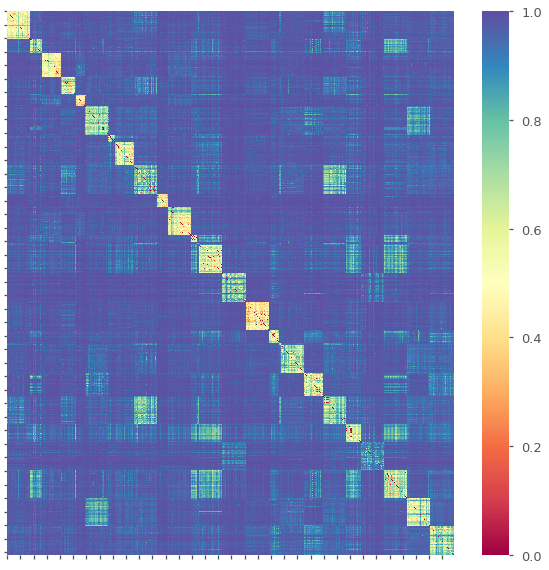

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])

### DBSCAN (4 балла)

* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Не копипастите min_pts = 2 из семинара! Используйте косинусную меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью Adjusted Rand Index

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [ ]:
min_samples = 5
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(tfidf)

NearestNeighbors()

In [ ]:
dist , _ = nn.kneighbors(tfidf)
dist_last = dist[:, -1]
dist_last = np.sort(dist_last)

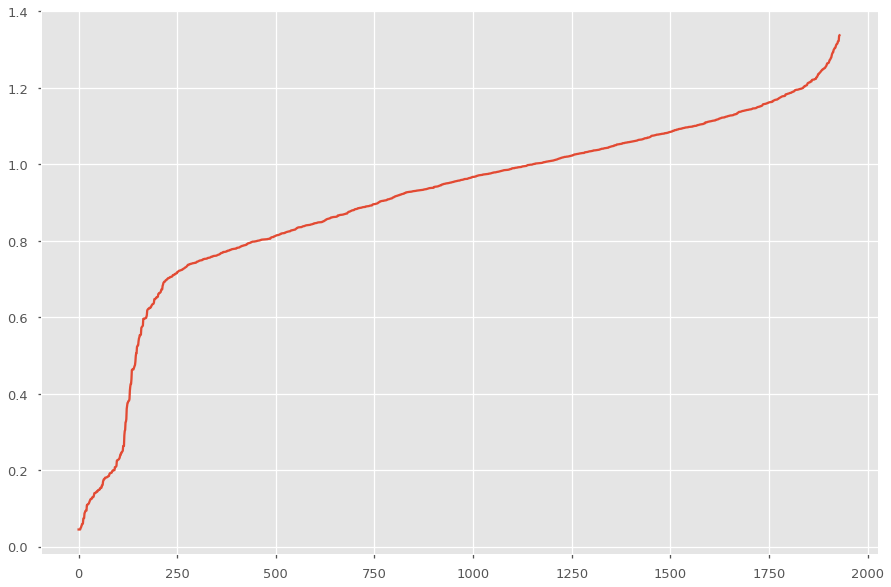

In [ ]:
plt.plot(dist_last);

In [ ]:
db_scan = DBSCAN(eps=0.66, min_samples=6, metric='cosine')
db_scan.fit(tfidf)

DBSCAN(eps=0.66, metric='cosine', min_samples=6)

In [ ]:
df_ = pd.read_csv('https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/news.csv', encoding='utf8')
df_.loc[:, 'label'] =  db_scan.labels_

In [ ]:
df_.label.value_counts()

 1     756
 7     173
-1     136
 10    110
 11    100
 0     100
 13     99
 9      99
 2      84
 6      82
 3      61
 8      49
 4      41
 5      26
 14      8
 12      6
Name: label, dtype: int64

In [ ]:
for cluster, df_cluster in df_.groupby('label'):
    print(f'== Cluster {cluster} ==')
    print(f'Cluster size: {df_cluster.shape[0]}')
    df_cluster.drop(columns=["label"]).mean()
    print(df_cluster.text[:5])
    print()

== Cluster -1 ==
Cluster size: 136
128     Findnews.ru, Москва, 20 января 2017 ТРАМП ВЗЯ...
129     Труд (trud.ru), Москва, 20 января 2017 В ВАШИ...
251     Ежедневный журнал (ej.ru), Москва, 3 марта 20...
297     CNN: ВЛАДИМИР ПУТИН - САМЫЙ МОГУЩЕСТВЕННЫЙ ЧЕ...
298     РБК (rbc.ru), Москва, 14 марта 2017 КРЕМЛЬ ПР...
Name: text, dtype: object

== Cluster 0 ==
Cluster size: 100
0     В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...
1     Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...
2     Аргументы и Факты (aif.ru), Москва, 14 января...
3     Google Новости ТОП, Москва, 14 января 2017 АК...
4     Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...
Name: text, dtype: object

== Cluster 1 ==
Cluster size: 756
100     ИНАУГУРАЦИЯ 45-ГО ПРЕЗИДЕНТА США ДОНАЛЬДА ТРА...
101     Russia Today (russian.rt.com), Москва, 21 янв...
102     Flynews24.ru, Москва, 21 января 2017 ТРАМП ПО...
103     Дэлайт новости (delate.info), Москва, 21 янва...
104     Дэлайт новости (delate.info), Москва, 21 янва..

После кластеризации явно выделяются следующие кластеры:
* Туризм
* Спорт
* Технологии
* Катастрофы (теракты)

Новости связанные с политикой перемешиваются, но есть некоторые кластеры:
* Культура
* Опозиция
* Выборы
* Евровидение


In [ ]:
labels = db_scan.labels_

In [ ]:
pd.crosstab(df.loc[:, 'class'], labels)

col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
class,,,,,,,,,,,,,,,,
Важные мировые события,2,0,276,84,0,41,0,0,0,0,0,0,0,0,0,0
Внутренняя политика РФ,5,100,159,0,0,0,0,0,0,0,0,0,100,0,0,0
Внутренняя политика РФ: оппозиция,37,0,0,0,61,0,0,0,173,0,0,0,0,6,0,0
Внутренняя политика: культура,1,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0
Международные отношения,3,0,124,0,0,0,26,0,0,0,0,0,0,0,0,0
Международные отношения: Криминальная хроника,0,0,0,0,0,0,0,82,0,0,0,0,0,0,0,0
Проишествия РФ,1,0,0,0,0,0,0,0,0,0,0,0,0,0,99,0
Спорт,75,0,0,0,0,0,0,0,0,0,0,17,0,0,0,8
Спорт,9,0,0,0,0,0,0,0,0,0,0,93,0,0,0,0


In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

In [ ]:
le = LabelEncoder()
true_label = le.fit_transform(df['class'])
adjusted_rand_score(true_label, labels)

0.34551123389566374